In [10]:
import warnings

warnings.filterwarnings("ignore")

### Carregamento dos Dados não Tratados

In [22]:
import pandas as pd

df = pd.read_csv('../data/creditcard.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])

In [12]:
df.shape

(284807, 30)

### Escolha do número de Cluster

In [13]:
from sklearn.cluster import KMeans
from tqdm import tqdm

k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


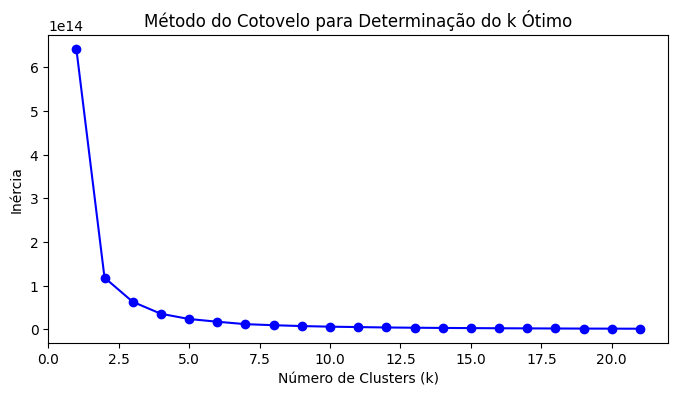

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vamos utilizar um cálculo para podermos encontrar o valor ótimo do número de clusters. Esse cálculo pode ser encontrado nesse blog [https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9].

In [15]:
from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances

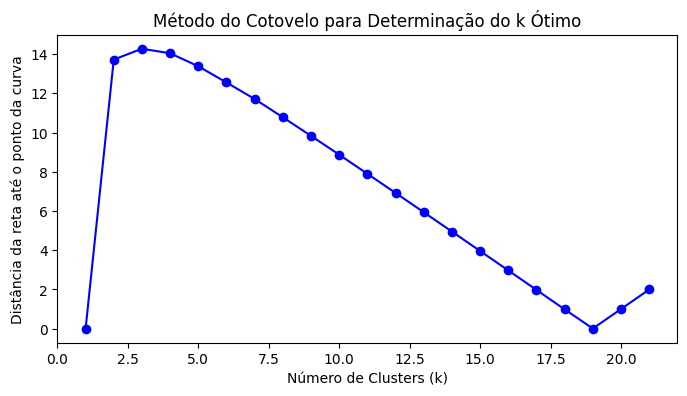

In [16]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vemos que o número ideal de cluster, que possui o maior valor de distância entre a linha e o ponto na curva, é 3. Então podemos trabalhar com 3 clusters para os dados não tratados. Vamos agora testar os nossos hiperparâmetros (random seed) para obter um modelo mais robusto.

In [17]:
import numpy as np

# Definir o número de clusters
k = 3

# Definir o número de inicializações diferentes
num_initializations = 999

best_inertia = np.inf
best_kmeans = None
best_random_seed = None

# Treinar o modelo com diferentes random_seed
for i in tqdm(range(num_initializations)):
    random_seed = i
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(df)
    
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_kmeans = kmeans
        best_random_seed = random_seed

print(f"Melhor random seed: {best_random_seed}")

100%|██████████| 999/999 [05:22<00:00,  3.10it/s]

Melhor random seed: 728


Como resultado, parece que a random seed 728 possui o menor valor de inércia dentro do nosso escopo.

In [18]:
print(f"Inércia: {best_kmeans.inertia_}")

Inércia: 63002531814954.87


In [20]:
# Obter os centróides do melhor modelo
centroids = best_kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../data/best_centroids.csv', index=False)

In [23]:
df['cluster'] = best_kmeans.labels_
df['Class'] = class_label

df.to_csv('../data/creditcard_clusters.csv', index=False)

### Carregamento dos Dados Tratados

In [24]:
df = pd.read_csv('/home/pedro/Documents/BIA/p3/PAD/trabalho-final/deteccao-de-fraude/data/creditcard_treated.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])

In [25]:
df.shape

(566506, 30)








### Escolha do número de Cluster do DF tratado

In [26]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


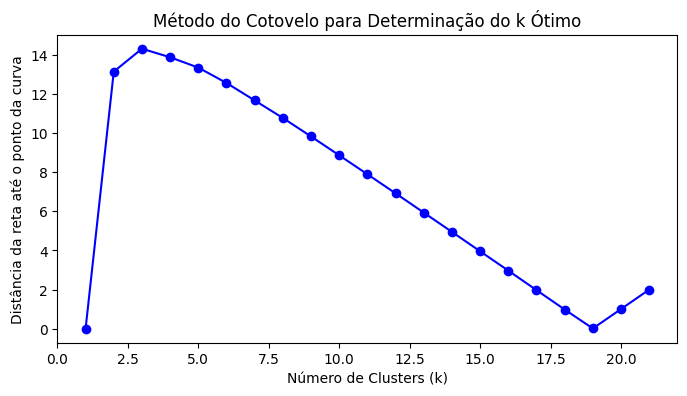

In [27]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Parece que se manteve o mesmo número ideal de clusters... Viva! E o hiperparâmetro?

In [28]:
# Definir o número de clusters
k = 3

# Definir o número de inicializações diferentes
num_initializations = 999

best_inertia = np.inf
best_kmeans = None
best_random_seed = None

# Treinar o modelo com diferentes random_seed
for i in tqdm(range(num_initializations)):
    random_seed = i
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(df)
    
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_kmeans = kmeans
        best_random_seed = random_seed

print(f"Melhor random seed: {best_random_seed}")

100%|██████████| 999/999 [09:34<00:00,  1.74it/s]

Melhor random seed: 434


Opa! Mudou...

In [29]:
print(f"Inércia: {best_kmeans.inertia_}")

Inércia: 127339406521014.45


A inércia está muito mais alta em comparação, o que parece fazer sentido como o volume da dos dobrou.

In [30]:
# Obter os centróides do melhor modelo
centroids = best_kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../data/best_centroids_df_treated.csv', index=False)

In [31]:
df['cluster'] = best_kmeans.labels_
df['Class'] = class_label

df.to_csv('../data/creditcard_treated_clusters.csv', index=False)